# Exploring data normalization and analysis in large TMT experimental designs
# Part 3 - Alternative statistical testing

### Phil Wilmarth, OHSU PSR Core, February 2018
In Part 1, several normalization methods were used on a developing mouse lens TMT study that spanned three 6-plex TMT labeling experiments. It was clear that an IRS-like procedure is critical to combining data from multiple TMT experiments because the different TMT experiments act like different batches. We also saw that increases in expression of several highly abundant lens proteins during the time course created a compositional bias in the samples that could be corrected by procedures like TMM.

In the second part, we explored how using or not using IRS affects downstream statistical testing. We used an RNA-Seq bioconductor package called edgeR to do a pairwise test where the two earliest time points were compared to the two latest time points. Crystallin expression would be greatly increased in the later times and this created a distinctive expression pattern.

Here we will do the same comparison but using a ratio-based methodology rather than IRS normalization. We will use the experiment-wide average intensities as internal references and take the ratio of the 6 time points to the reference. If we do that in each TMT experiment, it should remove any TMT experiment dependency. That difference will be that we will have altered quantities (ratios) rather than adjusted intensities.

<br> 


## Load the data and clean up some things
We just want a basic gene/protein expression table to work with in R. We can always stitch data structures together and then write them out later. We want one row for each protein and columns for each biological sample.

In [1]:
# Analysis of IOVS mouse lens data (Supplemental Table S01):
# Khan, Shahid Y., et al. "Proteome Profiling of Developing Murine Lens Through Mass Spectrometry." 
# Investigative Ophthalmology & Visual Science 59.1 (2018): 100-107.

# load libraries
library(tidyverse) # modern R packages for big data analysis
library(limma) # edgeR will load this if we do not
library(edgeR)

# read the Supplemental 01 file (saved as a CSV export from XLSX file)
data_start <- read_csv("iovs-58-13-55_s01.csv")

# filter out proteins not seen in all three runs
data_no_na <- na.omit(data_start)

# fix the column headers
col_headers <- colnames(data_no_na)
col_headers <- str_replace(col_headers, " {2,3}", " ")
col_headers <- str_replace(col_headers, "Reporter ion intensities ", "")
colnames(data_no_na) <- col_headers

# save the annotation columns (gene symbol and protein accession) for later and remove from data frame
annotate_df <- data_no_na[1:2]
data_raw <- data_no_na[3:20]
row.names(data_raw) <- annotate_df$`Protein Accession No.`

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Parsed with column specification:
cols(
  .default = col_double(),
  `Gene Symbol (NCBI)` = col_character(),
  `Protein Accession No.` = col_character()
)
See spec(...) for full column specifications.
Warning message:
“Setting row names on a tibble is deprecated.”

## First do SL normalizations and then create the "reference" vector
Sample loading inconsistencies seem common in TMT experiments and it is reasonable to correct for that before doing anything else.

In [2]:
# separate the TMT data by experiment
exp1_raw <- data_raw[c(1:6)]
exp2_raw <- data_raw[c(7:12)]
exp3_raw <- data_raw[c(13:18)]

# figure out the global target scaling value
target <- mean(c(colSums(exp1_raw), colSums(exp2_raw), colSums(exp3_raw)))

# do the sample loading normalizations (scale to the target value)
norm_facs <- target / colSums(exp1_raw)
exp1_sl <- sweep(exp1_raw, 2, norm_facs, FUN = "*")
norm_facs <- target / colSums(exp2_raw)
exp2_sl <- sweep(exp2_raw, 2, norm_facs, FUN = "*")
norm_facs <- target / colSums(exp3_raw)
exp3_sl <- sweep(exp3_raw, 2, norm_facs, FUN = "*")
data_sl <- cbind(exp1_sl, exp2_sl, exp3_sl)

# make data frame with row means from each TMT experiment
refs <- tibble(rowMeans(exp1_sl), rowMeans(exp2_sl), rowMeans(exp3_sl))
colnames(refs) <- c("ave1", "ave2", "ave3")

# make new data frame with ratio values (time points divided by the "reference")
data_ratio <- exp1_sl / refs$ave1
data_ratio <- cbind(data_ratio, exp2_sl / refs$ave2)
data_ratio <- cbind(data_ratio, exp3_sl / refs$ave3)
row.names(data_ratio) <- annotate_df$`Protein Accession No.`

In [3]:
head(exp1_raw)
round(target, 0)
head(exp1_sl)

E15_Set1,E18_Set1,P0_Set1,P3_Set1,P6_Set1,P9_Set1
1069664652,1457114681,1179045944,1455372629,1289042085,1407632648
526906032,784281820,534395113,600416635,569878248,647355498
586695635,792968077,553232976,626183065,528280042,578745749
315209709,488623202,362367811,433275153,396120791,445134422
30064315,43240455,25447349,95541340,199771510,368264651
121970802,209140086,189655080,201060109,237678671,309076418


[1] 9826475337

E15_Set1,E18_Set1,P0_Set1,P3_Set1,P6_Set1,P9_Set1
680111702,964061135,1164857264,1423295532,1480832527,1522721572
335016173,518899186,527964183,587183170,654667722,700283688
373031460,524646217,546575351,612381696,606880317,626064362
200415907,323284533,358007064,423725565,455057720,481528890
19115423,28608896,25141115,93435564,229494563,398374199
77551193,138371970,187372764,196628649,273041750,334346699


## Let's check the distributions
Remember, the developing lens over-expresses crystallins and kind of pushes everything else down. I do not know if TMM normalization works with numbers that have the scale and range that ratios have. 

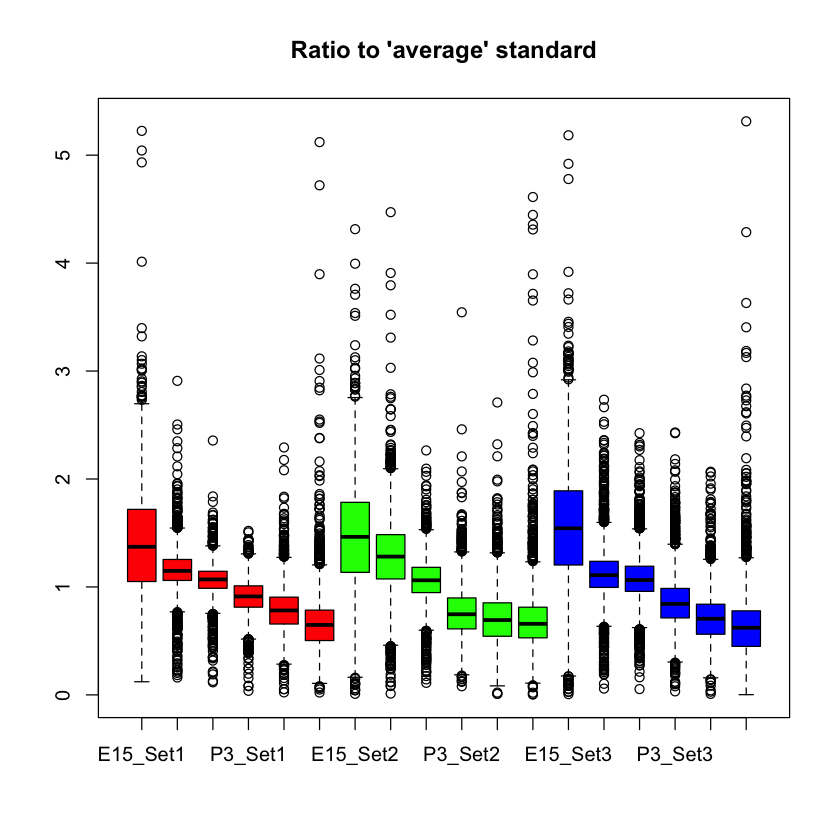

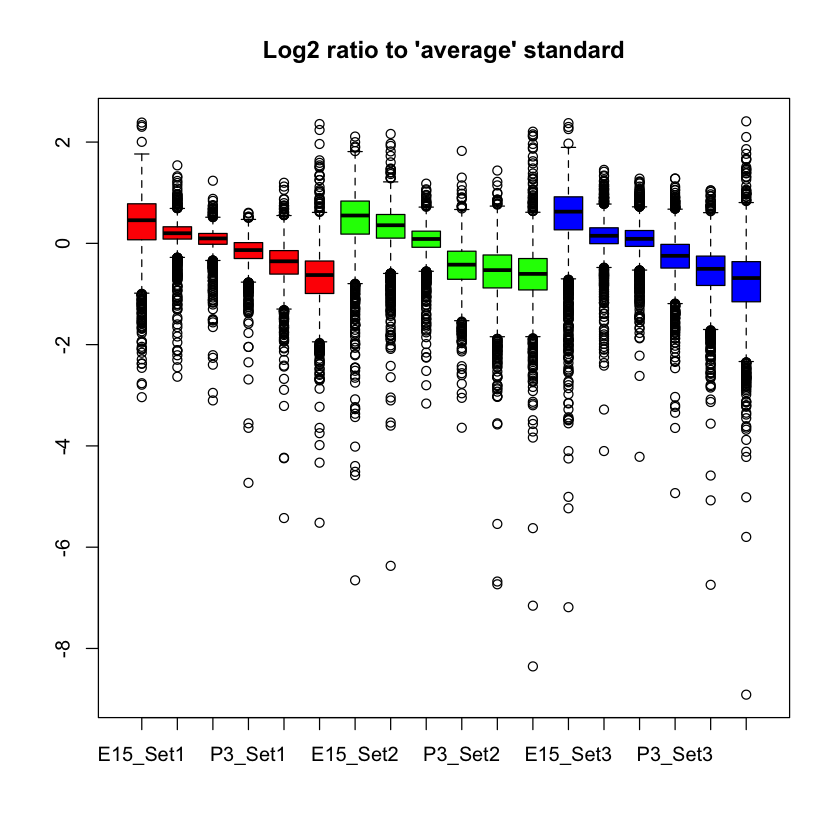

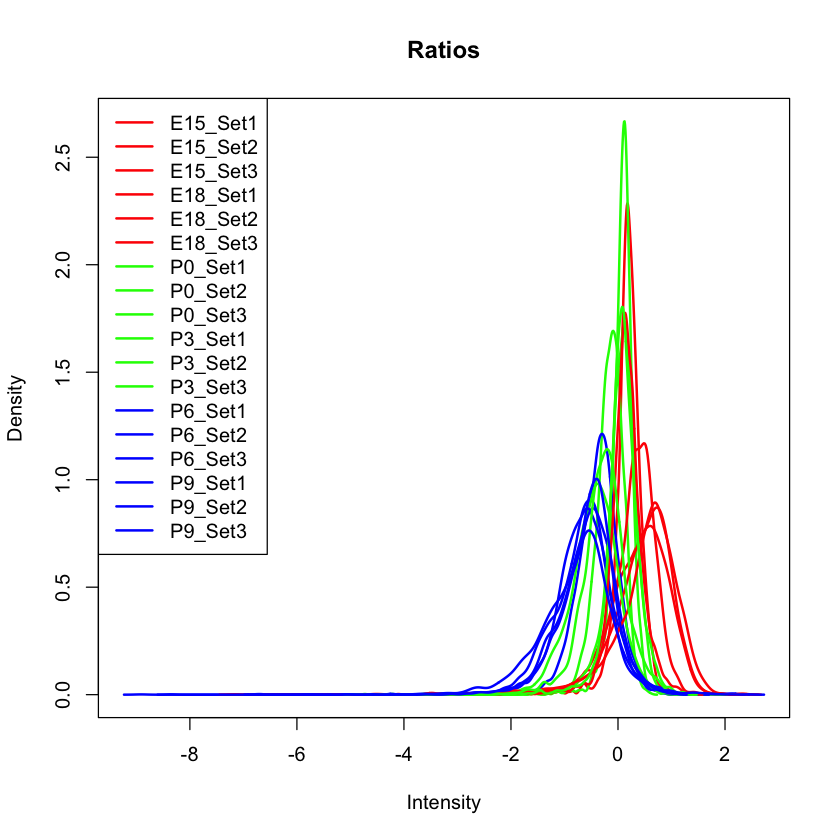

In [4]:
# let's see what box plots look like
boxplot(data_ratio, col = rep(c("red", "green", "blue"), each = 6), main = "Ratio to 'average' standard")
boxplot(log2(data_ratio), col = rep(c("red", "green", "blue"), each = 6), main = "Log2 ratio to 'average' standard")
plotDensities(log2(data_ratio), col = rep(c("red", "green", "blue"), each = 6), main = "Ratios")

## Double check that things cluster correctly
Ratios compared to total protein intensities look more extreme in their dependence on developmental time points. The intensities after SL normalization looked pretty good in the density plots. There seems to be some differences between above in the three experiments even after taking the ratios.

### Let's see what the multi-dimensional scaling plot looks like:

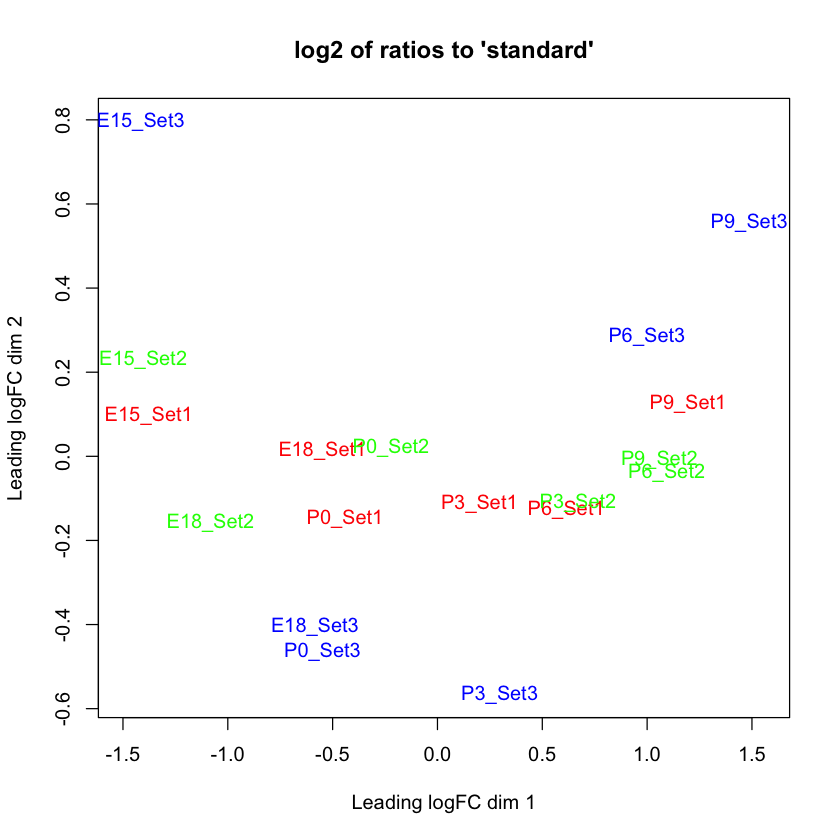

In [5]:
plotMDS(log2(data_ratio), col = rep(c("red", "green", "blue"), each = 6),
       main = "log2 of ratios to 'standard'")

## We do not have any clustering by TMT experiment
We do not seem to have any obvious "batch" effects, so we can try some statistical testing.

## Let's do a basic two sample t-test using R functions
R has built in t-test and multiple-testing functions. We will try those first.

In [6]:
# collect the 6 early versus the 6 late columns
early <- data_ratio[c(1, 2, 7, 8, 13, 14)]
late <- data_ratio[c(5, 6, 11, 12, 17, 18)]

# get the data into a separate data frame so we can apply the t-test to each row
# to be safe, take the log2 of the ratios (maybe this helps for ratios less than one?)
pair <- data.frame(log2(early), log2(late))

# add average ratio columns (non-logged ratios), fold-change column, and row names
pair$ave_early <- rowMeans(early)
pair$ave_late  <- rowMeans(late)
pair$logFC <- log2(pair$ave_late / pair$ave_early)
row.names(pair) <- annotate_df$`Protein Accession No.`

# apply the t-test (from:https://stackoverflow.com/questions/25496693/
# how-to-do-t-test-two-samples-to-rows-of-a-dataframe-using-apply-family-functio)
# data is set up to do the two-sample t.test (a built-in) on each row
t.result <- apply(pair, 1, function(x) t.test(x[1:6], x[7:12]))
# extract the p-value column from the t-test thingy 
pair$p_value <- unlist(lapply(t.result, function(x) x$p.value))
# do a Benjamini-Hochberg multiple testing correction
pair$fdr <- p.adjust(pair$p_value, method = "BH")
head(pair)

# add a DE candidate status column
pair$candidate <- "no"
pair[which(pair$fdr <= 0.10 & pair$fdr > 0.05), dim(pair)[2]] <- "low"
pair[which(pair$fdr <= 0.05 & pair$fdr > 0.01), dim(pair)[2]] <- "med"
pair[which(pair$fdr <= 0.01), dim(pair)[2]] <- "high"
pair$candidate <- as.factor(pair$candidate)
    
# count up, down and the rest (FDR less than 0.05)
all <- dim(pair)[1]
up <- dim(pair[(pair$fdr <= 0.05) & (pair$logFC > 0.0), ])[1]
down <- dim(pair[(pair$fdr <= 0.05) & (pair$logFC <= 0.0), ])[1]
up 
all - up - down
down


,E15_Set1,E18_Set1,E15_Set2,E18_Set2,E15_Set3,E18_Set3,P6_Set1,P9_Set1,P6_Set2,P9_Set2,P6_Set3,P9_Set3,ave_early,ave_late,logFC,p_value,fdr
P24622,-0.8263623,-0.32300939,-1.1084763,-0.5595042,-1.1920971,-0.08401440,0.2962026,0.3364462,0.3842863,0.3439461,0.2565596,0.2381516,0.64779400,1.239849,0.9365576,0.0024859251,0.0038147342
Q9JJU9,-0.7256614,-0.09443783,-0.8435372,-0.5267800,-0.5786212,-0.17774417,0.2408707,0.3380474,0.4031830,0.2138189,0.2616565,0.3416855,0.72440373,1.232336,0.7665301,0.0009635104,0.0017001539
Q9WVJ5,-0.5555714,-0.06352383,-0.4909545,-0.6536964,-0.5922684,0.05170228,0.1465433,0.1914423,0.2810475,0.1334590,0.2902871,0.2656288,0.78071693,1.164310,0.5766037,0.0037516824,0.0054773521
P04345,-0.8987675,-0.20896005,-1.1276987,-0.6708059,-1.2985680,-0.10702589,0.2842850,0.3658578,0.4390514,0.3228423,0.2493838,0.2358095,0.63705598,1.246538,0.9684344,0.0030800784,0.0046011588
P62696,-2.7916759,-2.20994920,-6.6544447,-6.3682963,-7.1853633,-4.10145656,0.7939750,1.5896393,0.8640601,1.7150815,0.7864775,1.6716922,0.07461964,2.459605,5.0427274,0.0006931538,0.0012856557
Q61597,-1.3755445,-0.54021365,-1.4951996,-1.3249809,-1.8666162,-0.36432632,0.4403562,0.7325795,0.6783437,0.7811746,0.3804392,0.5538518,0.47966832,1.517853,1.6619226,0.0004657264,0.0009359025


[1] 121

[1] 503

[1] 2531

## It is always good to double check that the p-value distribution is sensible 

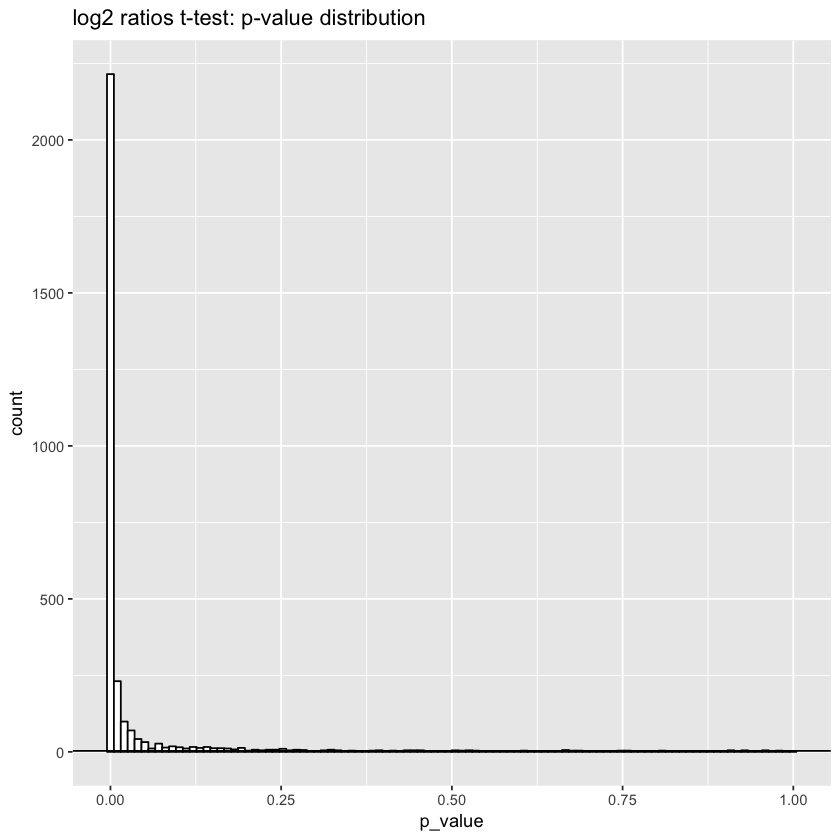

In [7]:
# what does the test p-value distribution look like?
ggplot(pair, aes(p_value)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(pair$p_value, breaks = 100, plot = FALSE)$counts[26:100])) +
  ggtitle("log2 ratios t-test: p-value distribution")

## Visualize the DE candidates 
We will do the usual FDR cutoffs ("no" > 0.1 > "low" > 0.05 > "med" > 0.01 > "high") for color highlighting. The scatter plots will be of the non-logged ratio values, averaged across the 6 time points in each group. Ratios have a much more limited dynamic range compared to intensities.

[1] "here"


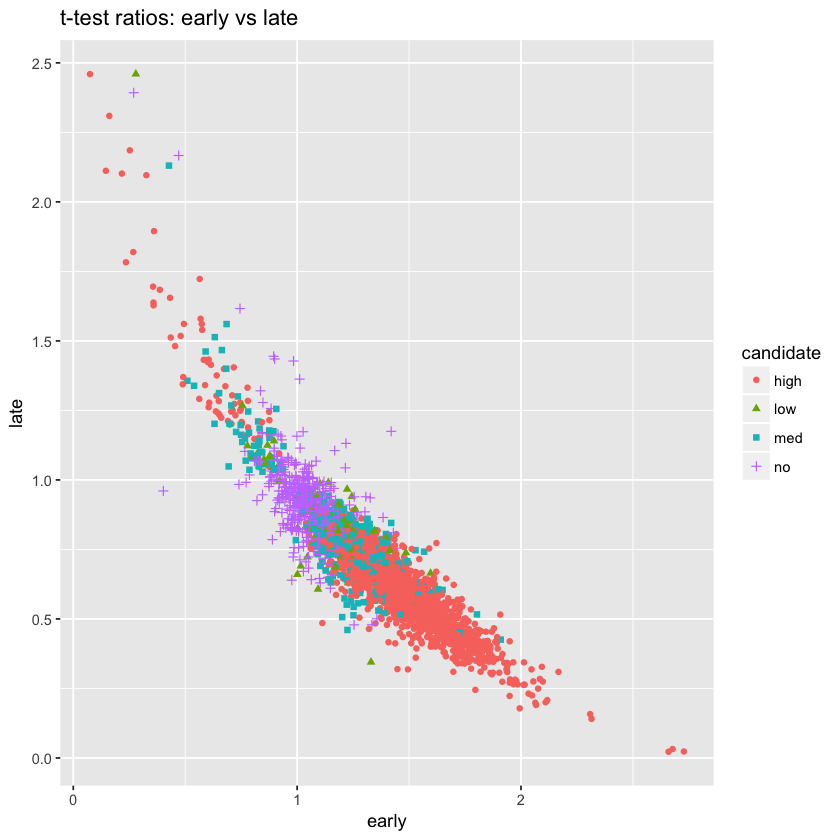

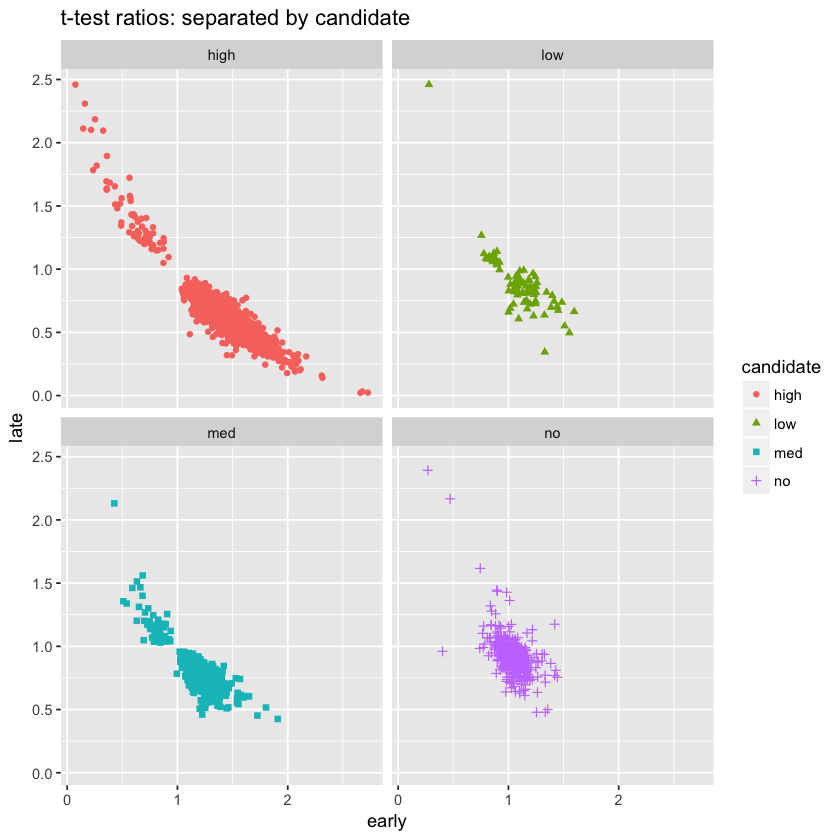

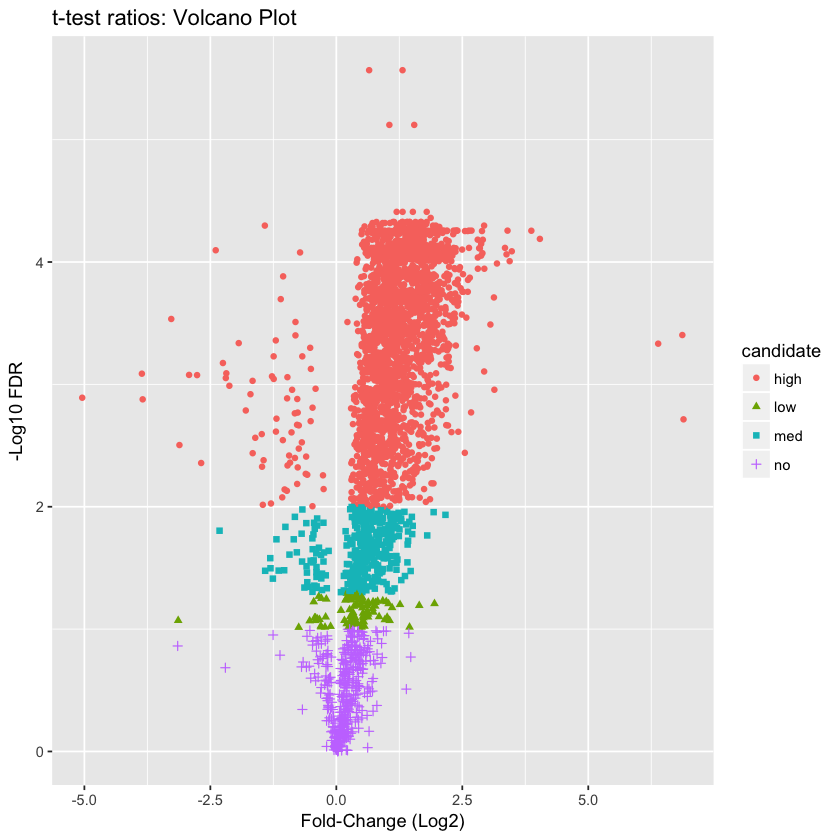

In [8]:
# make the combined candidate corelation plot
de_ratio <- data.frame(pair$ave_early, pair$ave_late, pair$candidate)
colnames(de_ratio) <- c("early", "late", "candidate")
ggplot(de_ratio, aes(x = early, y = late)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  ggtitle("t-test ratios: early vs late")

print('here')
# make separate corelation plots
ggplot(de_ratio, aes(x = early, y = late)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  facet_wrap(~ candidate) +
  ggtitle("t-test ratios: separated by candidate")

# make a volcano plot
vc <- data.frame(-1*pair$logFC, -1*log10(pair$fdr), pair$candidate)
colnames(vc) <- c("logFC", "fdr", "candidate")
ggplot(vc, aes(x = logFC, y = fdr)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  xlab("Fold-Change (Log2)") +
  ylab("-Log10 FDR") +
  ggtitle("t-test ratios: Volcano Plot")

## limma might be a better choice than the t-test 
limma can do more complicated study designs and we may have cases where a t-test will not be adequate. We have to deal with the complexities of using linear models to set things up for limma function calls. We will have to specify an experimental design matrix for the modeling. The data should already be normalized (I think) and transformed correctly. I think that means log transformed because most expression factors are multiplicative. We want those factors to be additive so that they can be modeled linearly. 

In [9]:
# recycle the data frame from above
old_pair <- pair
pair <- pair[1:12]

# create a basic design matrix (we collected the 6 early times first, then the 6 late times)
# the data in "pairs" was already log2 transformed
groups <- factor(rep(c("early", "late"), each = 6))
design <- model.matrix(~ groups)
design

,(Intercept),groupslate
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,1
8,1,1
9,1,1
10,1,1


## Model the protein expression and specify comparison
We are doing a simple early versus late comparison here, so the design matrix is pretty simple. The user's guides for limma and edgeR have some examples of design matrices. Another part is that the p-values depend on what contrasts are of interest. This is related to general linear models and modeling in R. I have not found a clear (to me) overview of this topic online yet. Some Google searching and reading are recommended.

In [10]:
# do the linear model fitting
fit <- lmFit(pair, design)
# do the empirical Bayes moderation of the test statistic
fit <- eBayes(fit, trend = TRUE)

# grab the information in topTable so we can get the data to plot candidates
# the coef parameter has to do with the contrast of interest
# specify no sorting of results and a number that is longer than the data table
tt_limma <- topTable(fit, coef = ncol(design), sort.by = "none", number = 10000)

# let's see what columns we have
head(tt_limma)
summary(decideTests(fit))

,logFC,AveExpr,t,P.Value,adj.P.Val,B
P24622,0.9915094,-0.18648926,5.180144,6.358009e-05,1.120643e-04,1.6552057
Q9JJU9,0.7910073,-0.09562665,5.645918,2.373216e-05,4.726955e-05,2.6373709
Q9WVJ5,0.6021200,-0.08299202,4.367536,3.736392e-04,5.629568e-04,-0.1029041
P04345,1.0348427,-0.20121636,5.027816,8.821536e-05,1.510963e-04,1.3292675
P62696,6.1220186,-1.82418836,5.999993,1.141812e-05,2.582377e-05,3.3672737
Q61597,1.7556043,-0.28334469,6.867957,2.036519e-06,6.299232e-06,5.0868182


       (Intercept) groupslate
Down           127       2581
NotSig         966        444
Up            2062        130

## We need to get the data and the test results (FDRs) together for plotting
This is repeated from above

In [11]:
# add average ratio columns (not logged), fold-change, and row names
pair$ave_early <- rowMeans(early)
pair$ave_late  <- rowMeans(late)
pair$logFC <- log2(pair$ave_late / pair$ave_early)
row.names(pair) <- annotate_df$`Protein Accession No.`

# get the p-values and FDRs from the top tests
pair$p_value <- tt_limma$P.Value
pair$fdr <- tt_limma$adj.P.Val
# see if we have what we want
# head(pair)

# add a DE candidate status column
pair$candidate <- "no"
pair[which(pair$fdr <= 0.10 & pair$fdr > 0.05), dim(pair)[2]] <- "low"
pair[which(pair$fdr <= 0.05 & pair$fdr > 0.01), dim(pair)[2]] <- "med"
pair[which(pair$fdr <= 0.01), dim(pair)[2]] <- "high"
pair$candidate <- as.factor(pair$candidate)
    
# count up, down and the rest (FDR less than 0.05)
all <- dim(pair)[1]
up <- dim(pair[(pair$fdr <= 0.05) & (pair$logFC > 0.0), ])[1]
down <- dim(pair[(pair$fdr <= 0.05) & (pair$logFC <= 0.0), ])[1]
up 
all - up - down
down

[1] 130

[1] 444

[1] 2581

## Check p-value distribution

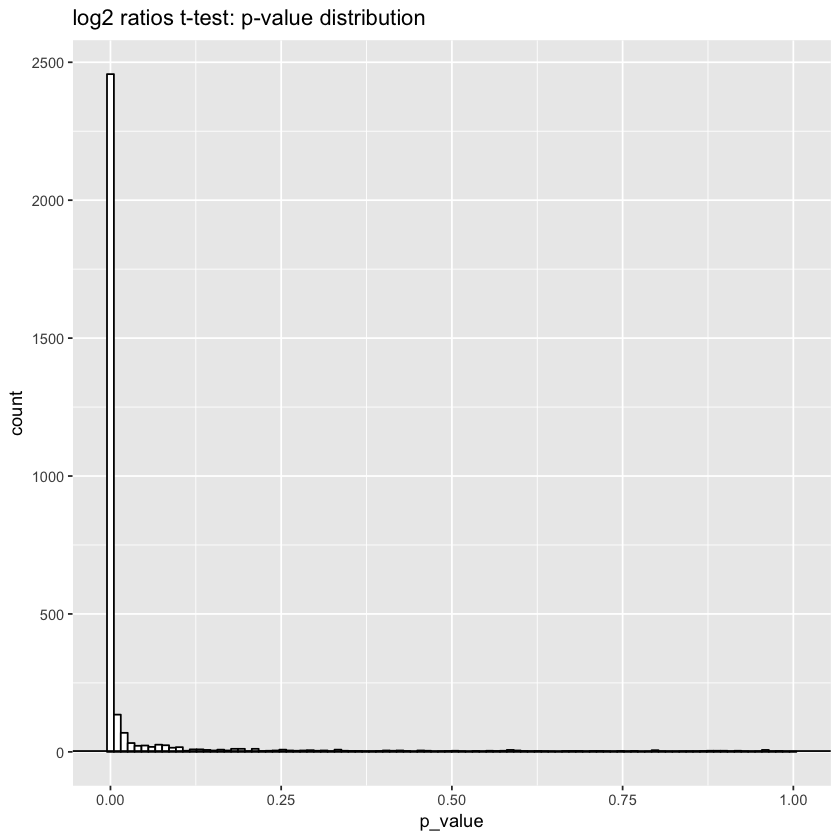

In [12]:
# what does the test p-value distribution look like?
ggplot(pair, aes(p_value)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(pair$p_value, breaks = 100, plot = FALSE)$counts[26:100])) +
  ggtitle("log2 ratios t-test: p-value distribution")

## Do the visualization of the limma results

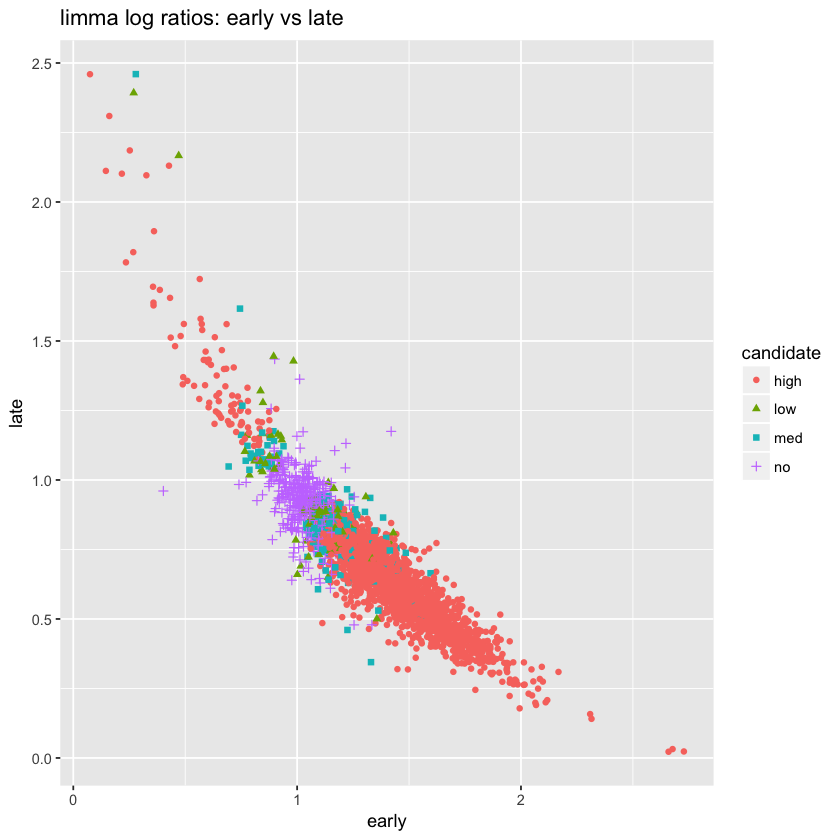

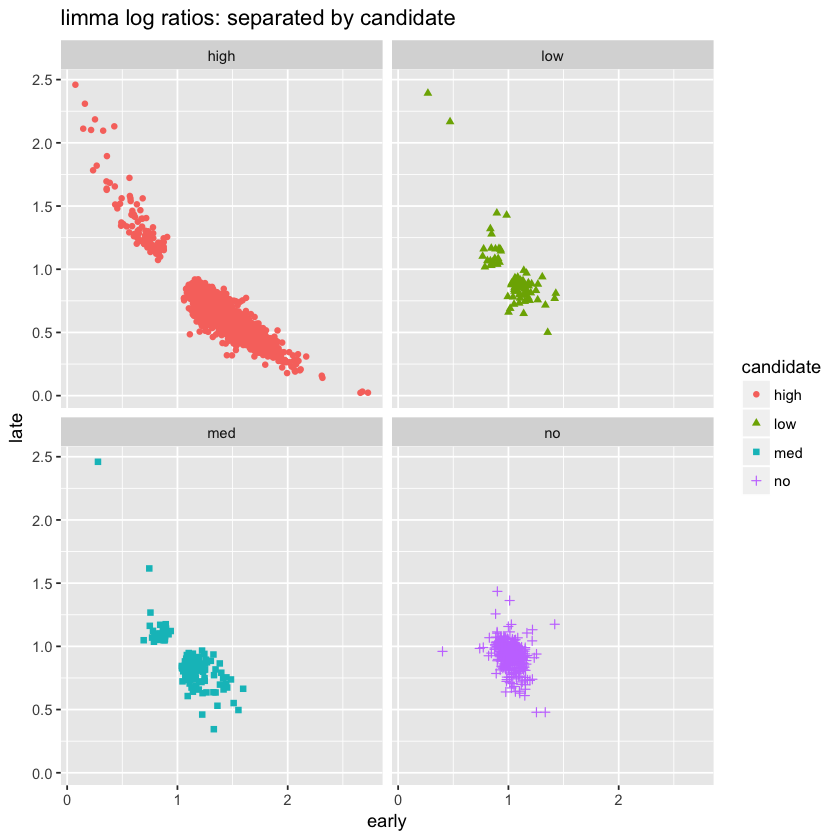

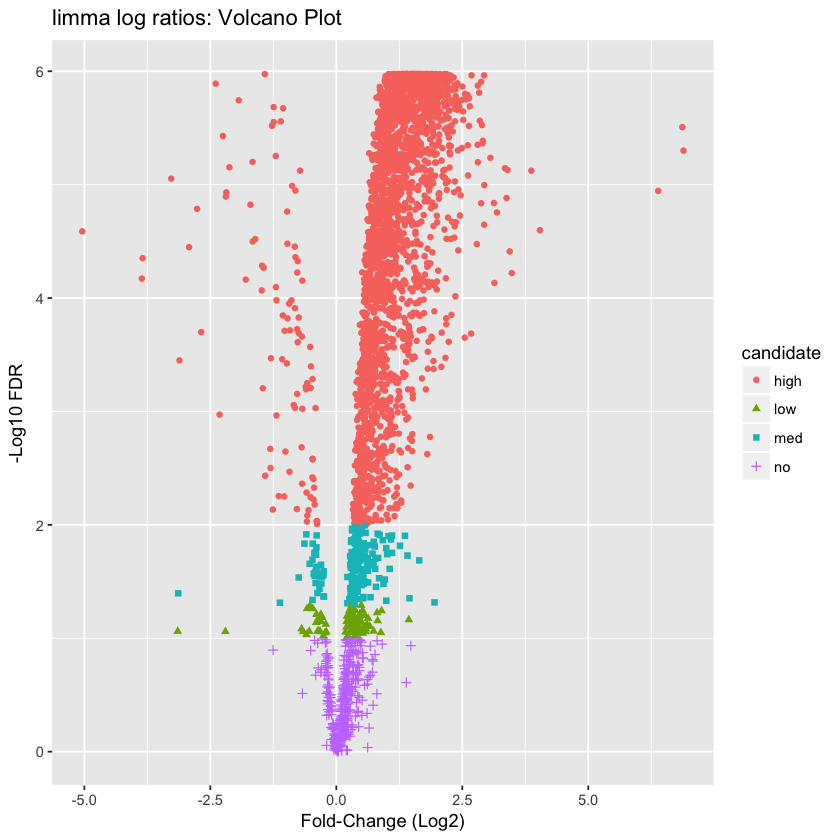

In [13]:
# make the combined candidate corelation plot
de_ratio <- data.frame(pair$ave_early, pair$ave_late, pair$candidate)
colnames(de_ratio) <- c("early", "late", "candidate")
ggplot(de_ratio, aes(x = early, y = late)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  ggtitle("limma log ratios: early vs late")

# make separate corelation plots
ggplot(de_ratio, aes(x = early, y = late)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  facet_wrap(~ candidate) +
  ggtitle("limma log ratios: separated by candidate")

# make a volcano plot
vc <- data.frame(-1*pair$logFC, -1*log10(pair$fdr), pair$candidate)
colnames(vc) <- c("logFC", "fdr", "candidate")
ggplot(vc, aes(x = logFC, y = fdr)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  xlab("Fold-Change (Log2)") +
  ylab("-Log10 FDR") +
  ggtitle("limma log ratios: Volcano Plot")

## Using ratios instead of IRS-adjusted intensities seems to work OK
### We get similar numbers of up and down regulated candidates compared to the edgeR analysis in Part 2.
Normalization aspects of ratios were less easy to understand. Box plots and density plots did not look that good, but the cluster plot seemed OK.

The candidate plots are much less informative to my eye. Any relative protein abundance information (between different proteins) is lost. The general expression pattern is still pretty clear. The majority of the proteins have higher expression ratios in the early lenses compared to the later time points.

limma p-values seem to have more dynamic range than the basic two-sample t-test and that can be seen in the volcano plots. limma is more designed for these types of data sets that a basic t-test. Six replicates per condition is probably too few for the t-test. limma looks like a better choice.

To do further work with the results, some of the data frames should be combined, such as the original data, the computed "standard" columns, ratios, and statistical results. The final data frame can then be written to a CSV file for further work (adding annotations, etc.). There are plenty of other options available in limma and in BioConductor for annotations and enrichment analyses.

There are some good resources out there for RNA-Seq analysis with edgeR and limma:
http://combine-australia.github.io/RNAseq-R/06-rnaseq-day1.html

In [14]:
# collect up some results to write out
final <- cbind(annotate_df, data_raw, data_sl, refs, data_ratio, pair)
write.csv(final, file = "final_part3.csv")

## One last test with ratios
### Does forming ratios make the biological replicates at each time point more similar between different TMT experiments?
It is kind of hard to figure out what to try and plot. We do not have before and after like we did with IRS. Intensities are stretched out over a wide range and that lends itself to scatter plots and correlation coefficients. Ratios are more fuzzy dots instead of fuzzy lines. They may be hard to interpret.


Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



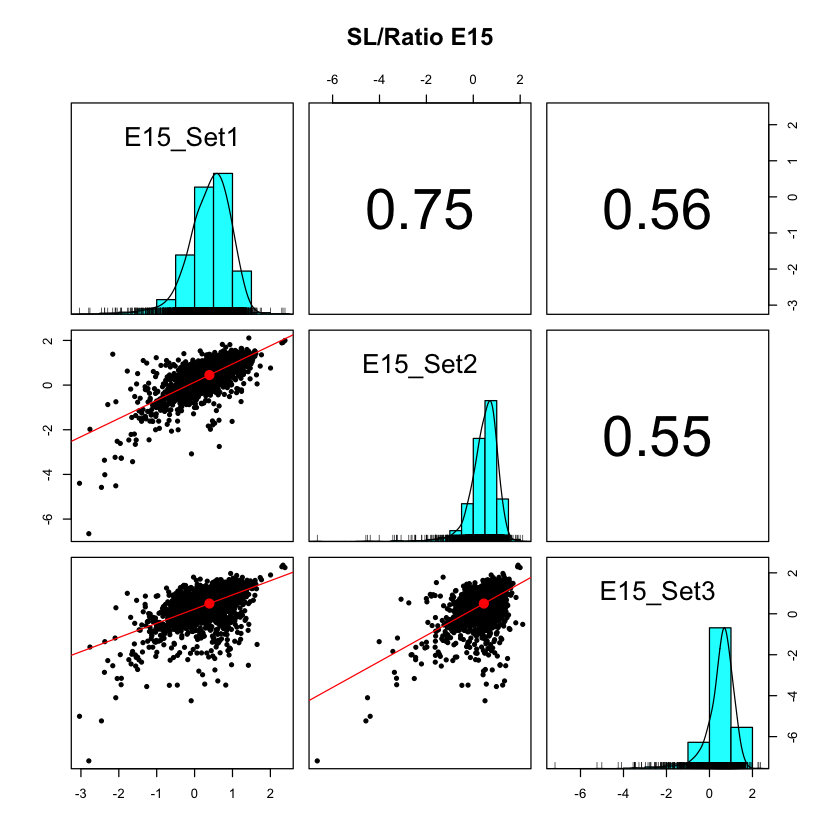

In [15]:
library(psych)
# lets compare the combination of SL and TMM normalizations to SL/IRS/TMM 
# again using the idea that replicates of the same time point should similar
pairs.panels(log2(data_ratio[c(1, 7, 13)]), lm = TRUE, main = "SL/Ratio E15")

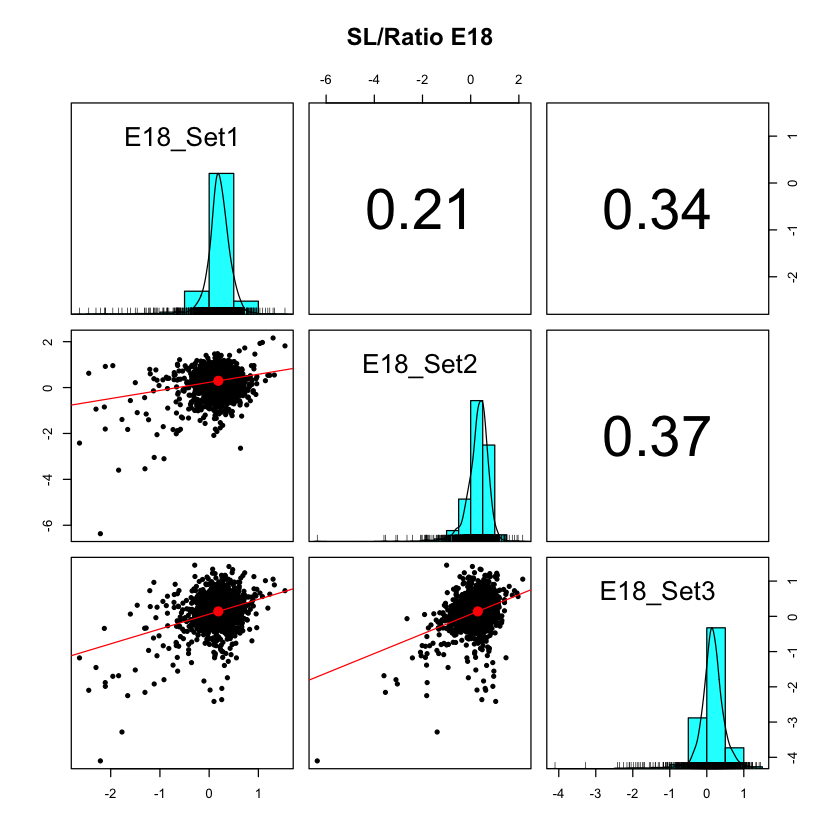

In [16]:
pairs.panels(log2(data_ratio[c(2, 8, 14)]), lm = TRUE, main = "SL/Ratio E18")

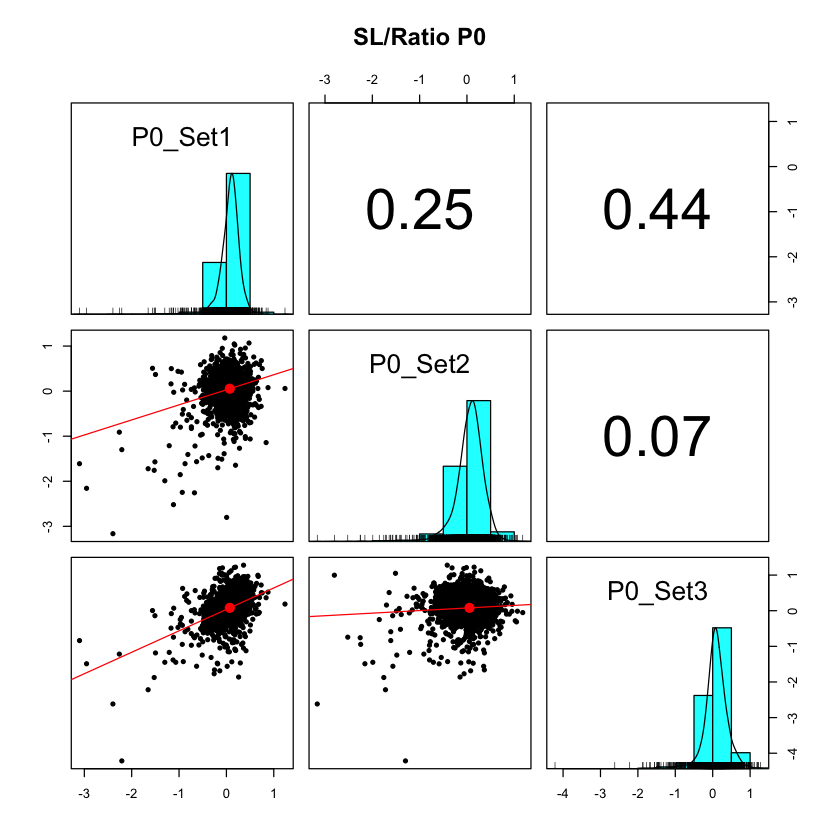

In [17]:
pairs.panels(log2(data_ratio[c(3, 9, 15)]), lm = TRUE, main = "SL/Ratio P0")

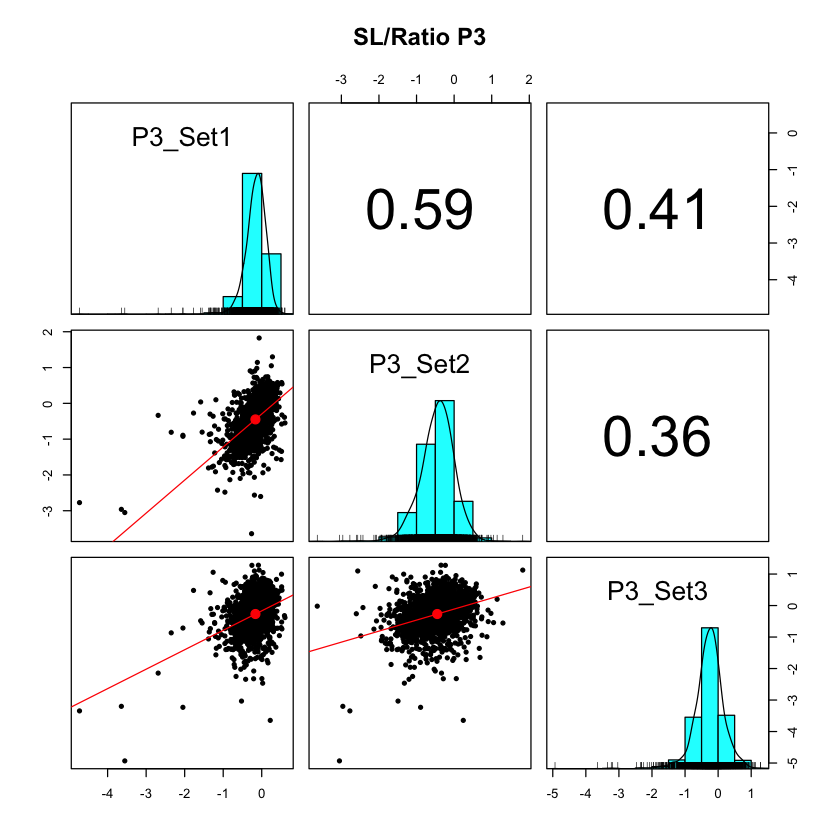

In [18]:
pairs.panels(log2(data_ratio[c(4, 10, 16)]), lm = TRUE, main = "SL/Ratio P3")

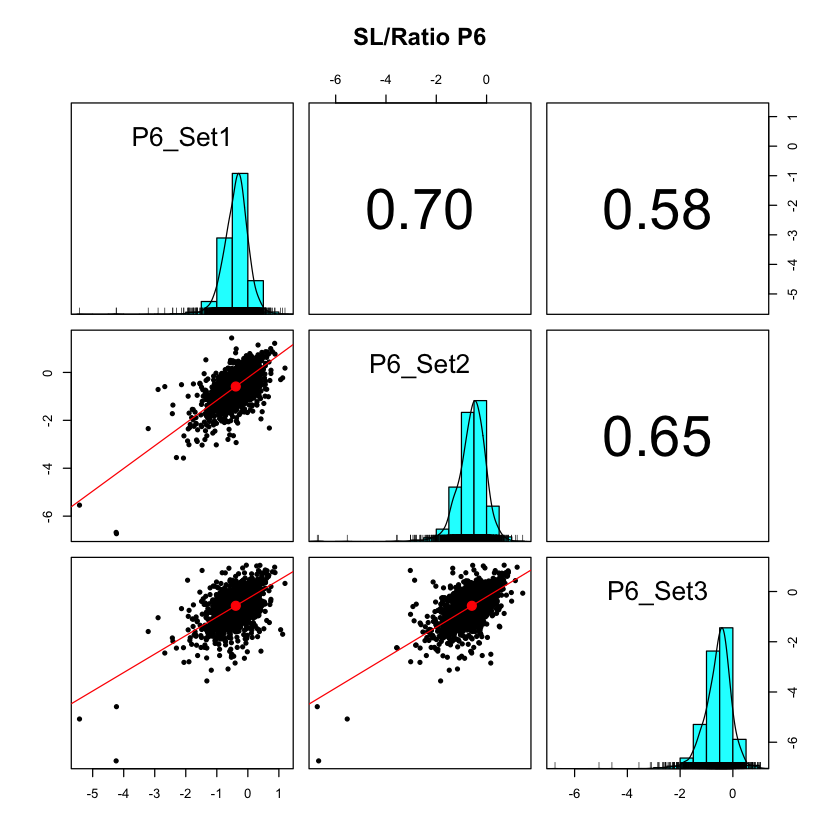

In [19]:
pairs.panels(log2(data_ratio[c(5, 11, 17)]), lm = TRUE, main = "SL/Ratio P6")

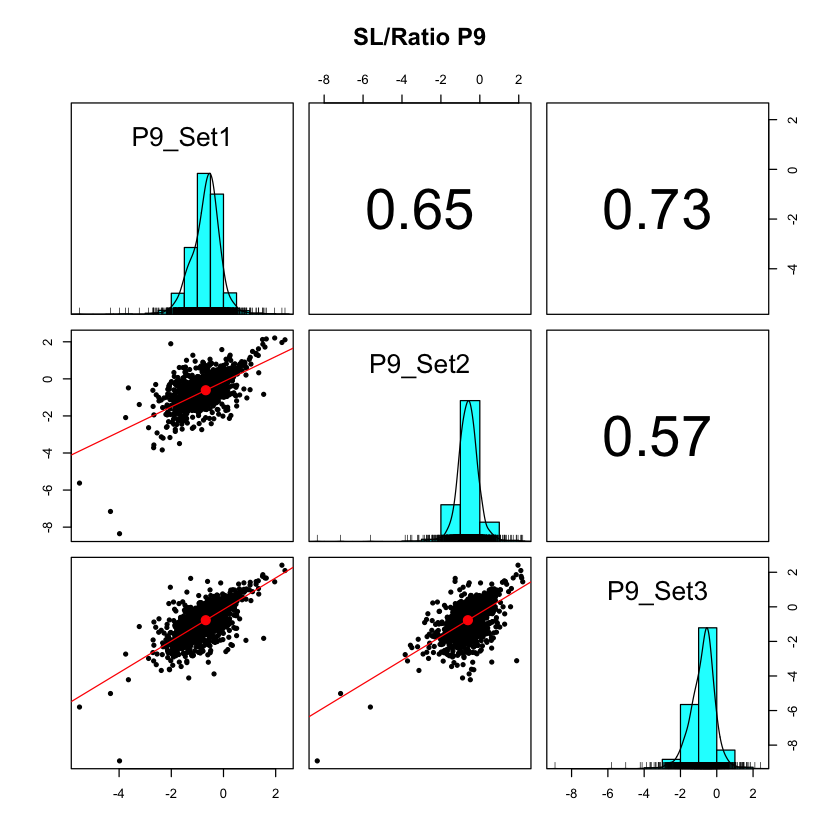

In [20]:
pairs.panels(log2(data_ratio[c(6, 12, 18)]), lm = TRUE, main = "SL/Ratio P9")

## The change in scale after forming ratios makes comparing similar sample by scatter plots kind of useless...